# Conditional Variational Autoencoder

###  <div align=center> Moon Il-chul(icmoon@kaist.ac.kr); Shin Dong-hyeok(tlsehdgur0@kaist.ac.kr); Bae Hee-sun(cat2507@kaist.ac.kr) </div> 

본 코드는 MNIST 데이터셋을 이용한 Conditional Variational Autoendocer의 구현 예시입니다.  
본 코드를 통해서 Conditional Variational Autoencoder의 구조와 생성, 학습 과정을 익힐 수 있습니다.  
또한 본 코드를 통하여 latent space를 plot 해봄으로써 latent varible의 정보를 살펴볼 수 있습니다. 

In [1]:
'''
@ copyright: AAI lab (http://aailab.kaist.ac.kr/xe2/page_GBex27)
@ author: Moon Il-chul: icmoon@kaist.ac.kr
@ annotated by Shin Dong-hyeok: tlsehdgur0@kaist.ac.kr; Bae Hee-sun: cat2507@kaist.ac.kr
'''

import time
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.manifold import TSNE

In [2]:
class CVariationalAutoEncoder:

    network_architecture = [] # network_architecture : 인공신경망의 구조를 저장
    transfer_fct = 0

    x = [] # x : VAE의 Input
    x_reconstr_mean = [] # x_reconstr_mean : VAE의 Output
    y = [] # y : Input의 label
    z = [] # z : VAE의 latent variable
    z_mean = [] # z_mean : VAE의 latent variable의 mean
    z_log_sigma_sq = [] # z_log_sigma_sq : VAE의 latent variable의 log sigma sq
    
    x_concat = [] # input과 label의 concatenation
    z_concat = [] # latent와 label의 concatenation

    sess = 0
    cost = 0
    optimizer = 0

    def __init__(self,network_architecture,transfer_fct=tf.nn.sigmoid):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct # self.transfer_fct : activation function을 저장, 기본값은 sigmoid function으롤 설정

        self.x = tf.placeholder(tf.float32,[None,network_architecture["n_input"]]) # input 
        self.y = tf.placeholder(tf.float32,[None, 10]) # label
        self.x_concat = tf.concat([self.x, self.y], 1) # input + label
        
    def _create_network(self,batch_size): 
        # VAE를 생성하는 method
        # initialize weight -> recognition network -> Reparameterization trick -> generator network
        
        network_weights = self._initialize_weights(**self.network_architecture)

        self.z_mean, self.z_log_sigma_sq = self._recognition_network(network_weights["weights_recog"],network_weights["biases_recog"])

        n_z = self.network_architecture["n_z"]
        
        # Reparameteriation trick
        eps = tf.random_normal((batch_size,n_z),0,1,dtype=tf.float32)

        self.z = tf.add(self.z_mean,tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)),eps)) # latent
        self.z_concat = tf.concat([self.z, self.y], 1) # latent + label

        self.x_reconstr_mean = self._generator_network(network_weights["weights_gener"],network_weights["biases_gener"])

    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, n_hidden_gener_1, n_hidden_gener_2, n_input, n_z):
        # VAE의 전체 weights의 초기값을 설정하여 dictionary로 return하는 method
        # Input : n_hidden_recog_1, n_hidden_recog_2, n_hidden_gener_1, n_hidden_gener_2, n_input, n_z
        # Output : all_weights
        
        all_weights = dict()
        
        # Recognition Network의 weight의 초기값 설정 with Xavier initialization
        all_weights['weights_recog'] = { 'h1' : tf.Variable(self.xavier_init(n_input+10,n_hidden_recog_1)), \
                                         'h2' : tf.Variable(self.xavier_init(n_hidden_recog_1,n_hidden_recog_2)), \
                                         'out_mean': tf.Variable(self.xavier_init(n_hidden_recog_2, n_z)), \
                                         'out_log_sigma': tf.Variable(self.xavier_init(n_hidden_recog_2, n_z))}

        # Recognition Network의 bias의 초기값 설정 with 0
        all_weights['biases_recog'] = { 'b1' : tf.Variable(tf.zeros([n_hidden_recog_1],dtype=tf.float32)), \
                                        'b2' : tf.Variable(tf.zeros([n_hidden_recog_2],dtype=tf.float32)), \
                                        'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)), \
                                        'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        
        # Generator Network의 weight의 초기값 설정 with Xavier initialization
        all_weights['weights_gener'] = {'h1': tf.Variable(self.xavier_init(n_z+10, n_hidden_gener_1)), \
                                        'h2': tf.Variable(self.xavier_init(n_hidden_gener_1, n_hidden_gener_2)), \
                                        'out_mean': tf.Variable(self.xavier_init(n_hidden_gener_2, n_input)), \
                                        'out_log_sigma': tf.Variable(self.xavier_init(n_hidden_gener_2, n_input))}
        
        # Generator Network의 bias의 초기값 설정 with 0
        all_weights['biases_gener'] = {'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)), \
                                       'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)), \
                                       'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)), \
                                       'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights

    def _recognition_network(self,weights,biases):
        # VAE의 recognition network의 역할을 수행하는 method
        # Input : (recognition network의) weights, biases
        # Output: (z_mean, z_log_sigma_sq)
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x_concat, weights['h1']), biases['b1'])) # L1 = g(b1 + W1*(X:Y))
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])) # L2 = g(b2 + W2*L1)
        z_mean = tf.add(tf.matmul(layer_2,weights['out_mean']),biases['out_mean']) # z_mean = b_{out_mean} + W_{out mean}*L2
        z_log_sigma_sq = tf.add(tf.matmul(layer_2,weights['out_log_sigma']),biases['out_log_sigma'])
        # z_log_sigma_sq = b_{log_sigma_sq} + W_{log_sigma_sq}*L2
        return (z_mean,z_log_sigma_sq)

    def _generator_network(self,weights,biases):
        # VAE의 generator network의 역할을 수행하는 method
        # Input : (generator network의) weights, biases
        # Output : x_reconstr_mean
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z_concat, weights['h1']), biases['b1'])) # L1 = g(b1 + W1*(Z:Y))
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])) # L2 = g(b2 + W2*L1)
        x_reconstr_mean = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), biases['out_mean']))
        # x_reconstr_mean = b_{out_mean}+W_{out_mean}*L2

        return x_reconstr_mean

    def _create_loss_optimizer(self,learning_rate):
        # VAE의 total cost를 계산하고, 이를 minimize하는 optimizer 설정하는 메소드
        # Input : learning_rate
        # Output : None
        
        # reconstruction loss function = binary cross-entropy function
        reconstr_loss = -tf.reduce_sum(self.x*tf.log(1e-10+self.x_reconstr_mean)+(1-self.x)*tf.log(1e-10+1-self.x_reconstr_mean),1)
        
        # latent loss function = KL-divergence
        latent_loss = -0.5*tf.reduce_sum(1+self.z_log_sigma_sq-tf.square(self.z_mean)-tf.exp(self.z_log_sigma_sq),1)
        
        # (VAE의 total) cost = reconstruction loss + latent loss 
        self.cost = tf.reduce_mean(reconstr_loss+latent_loss)
        
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.cost)

    def partial_fit(self,x,y):
        # VAE를 통하여 학습한 Input data x의 cost를 출력하는 메소드 
        # Input : x, y
        # Output : cost
        opt,cost = self.sess.run((self.optimizer,self.cost),feed_dict={self.x:x, self.y:y})
        return cost

    def transform(self,x,y):
        # VAE의 encoder network를 통하여 latent variable z의 mean을 return하는 메소드
        # Input : x, y
        # Output : z_mean
        return self.sess.run(self.z_mean,feed_dict={self.x:x, self.y:y})

    '''def generate(self, z_mu,y):
        # VAE의 decoder network를 통하여 output을 return하는 메소드
        # Input : z_mu, y
        # Output : x_reconstr_mean
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        return self.sess.run(self.x_reconstr_mean, feed_dict={self.z:z_mu, self.y:y})'''

    def reconstruct(self,x,y):
        # VAE를 통하여 X를 reconstruct한 후, 이의 mean을 return하는 메소드
        # Input : x, y
        # Output : (VAE를 통한) x_reconstr_mean
        return self.sess.run(self.x_reconstr_mean,feed_dict={self.x:x, self.y:y})

    def xavier_init(self,fan_in, fan_out, constant=1): 
        # Xavier initialization method
        # Input : fan_in(들어오는 layer의 크기), fan_out(나가는 layer의 크기)
        # Output : 각 원소가 random uniform value인 (fan_in, fan_out) 형태의 tensor 
        low = -constant * np.sqrt(6.0 / (fan_in + fan_out))
        high = constant * np.sqrt(6.0 / (fan_in + fan_out))

        return tf.random_uniform((fan_in, fan_out), minval=low, maxval=high, dtype=tf.float32)

    def train(self,trainX,trainY,batch_size=100,training_epochs=500,learning_rate=0.0005):
        # VAE를 생성하고, trainX/Y를 training하는 메소드
        # Input : trainX, trainY, batch_size, training_epochs, learning_rate
        # Output : None
        
        total_costs = np.zeros(training_epochs)
        
        self._create_network(batch_size) # VAE 생성
        self._create_loss_optimizer(learning_rate) # VAE의 loss function과 optimizer 생성

        init = tf.initialize_all_variables()
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
        self.sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
        # session : tensorflow를 올려놓아 실행을 진행하기 위한 공간
        self.sess.run(init)

        startTime = time.time()
        for epoch in range(training_epochs): # training_epochs만큼 반복 실행
            avg_cost = 0. # training set의 average cost 
            total_batch = int(len(trainX)/batch_size) # total batch : 전체 batch의 갯수

            for i in range(total_batch): # total_batch만큼 반복 실행
                batch = []
                batch_label = []
                for j in range(batch_size):
                    batch.append(trainX[i*batch_size+j]) # training X를 여러개 batch로 나누는 과정
                    batch_label.append(trainY[i*batch_size+j]) # training X에 대응하는 training Label 또한 여러개 batch로 나눈다
                    
                cost = self.partial_fit(batch,batch_label) # i번째 batch의 cost 계산
                avg_cost += cost / n_samples*batch_size
            
            total_costs[epoch] = avg_cost
            
            print("Epoch : ",'%04d'%(epoch+1)," Cost = ","{:.9f}".format(avg_cost))
            print("Elapsed Time : " + str((time.time() - startTime))) # 각 epcoh의 실행 소요 시간 
        
        # epcch에 따른 cost 그래프 출력 과정
        plt.plot(total_costs)
        plt.xlabel('epoch')
        plt.ylabel('cost')
        plt.show()
        return

    def plotReconstruct(self,testData,testAmount,strFileName):
        # testData를 CVAE를 통해 label을 붙여reconstruct한 후, Input test image와 reconstructed output image를 plot하는 메소드  
        idxLastSlash = strFileName.rfind("/")
        if os.path.exists(strFileName[0:idxLastSlash]) == False:
            os.makedirs(strFileName[0:idxLastSlash])
            
        # test data에 붙일 label 생성
        label = []
        for i in range(10):
            label.append([])
            for j in range(10):
                label[i].append(0)
            for k in range(10):
                if k == i:
                    label[i][k] = 1
            label[i] = np.array(label[i]) # 0~9 one hot vector : label[i] means i

        # x_reconstruct : testData와 testLabel을 이용하여 reconstruct한 데이터
        x_reconstruct = []
        for n in range(10):
            x_reconstruct.append([])
        for i in range(10):
            Labellist = []
            for data in range(testAmount):
                Labellist.append(label[i])
            Labellist = np.array(Labellist)
            x_reconstruct[i] = self.reconstruct(testData, Labellist) # reconstruct(testData, label[i])
            
        plt.figure(figsize=(35, 50))
        samplenum = 20
        for d_num in range(samplenum): # testData의 처음 samplenum개를 plot
            
            # Original Input image plot
            plt.subplot(samplenum, 11, 11 * d_num + 1) #원래 그림
            plt.imshow(testData[d_num].reshape(28, 28), vmin=0, vmax=1, cmap="gray") # 784 차원의 벡터를 28*28 픽셀의 이미지로 변환
            plt.title("Test Input")
            plt.colorbar()
            
            # Reconstructed Output image plot
            for l_num in range(10):
                plt.subplot(samplenum, 11, 11 * d_num + l_num + 2) # l num을 label로 reconstruction한 그림
                plt.imshow(x_reconstruct[l_num][d_num].reshape(28, 28), vmin=0, vmax=1, cmap="gray") # 784 차원의 벡터를 28*28 픽셀의 이미지로 변환
                plt.title("Reconstruction"+str(l_num))
                plt.colorbar()

        plt.tight_layout()
        plt.show()
        plt.savefig(strFileName, bbox_inches='tight')
        plt.close()

    def plotScatter2D(self,testDataFeature,testDataClass,strFileName):
        # test data와 label을 2-D latent Space위에 Scatter plot으로 표현하는 메소드
        
        idxLastSlash = strFileName.rfind("/")
        if os.path.exists(strFileName[0:idxLastSlash]) == False:
            os.makedirs(strFileName[0:idxLastSlash])

        z_mu = self.transform(testDataFeature,testDataClass)
        plt.figure(figsize=(8, 6))
        plt.scatter(z_mu[:,0],z_mu[:,1],c=np.argmax(testDataClass,1))
        plt.colorbar()
        plt.grid()

        plt.tight_layout()
        plt.show()
        plt.savefig(strFileName, bbox_inches='tight')
        plt.close()

In [3]:
np.random.seed(0)
tf.set_random_seed(0)

mnist = input_data.read_data_sets('MNIST_DATA',one_hot=True) # MNIST 데이터를 one-hot representation vector 형태로 다운로드한다.
n_samples = mnist.train.num_examples

iterations = [1,5]
testX = mnist.test.next_batch(100)[0] # testX : MNIST의 test 데이터셋 중에서 input(=image)을 100(=batch의 크기)만큼 batch로 저장 (100*784)
trainX = []
trainLabel = []
for i in range(n_samples): 
    tempTuple,tempLabel = mnist.train.next_batch(1)
    trainX.append(tempTuple[0])
    trainLabel.append(tempLabel[0])

W1127 00:34:42.206098 19344 deprecation.py:323] From <ipython-input-3-973a6f42a477>:4: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W1127 00:34:42.218091 19344 deprecation.py:323] From c:\users\bae\venv\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W1127 00:34:42.223090 19344 deprecation.py:323] From c:\users\bae\venv\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data t

Extracting MNIST_DATA\train-images-idx3-ubyte.gz


W1127 00:34:42.857726 19344 deprecation.py:323] From c:\users\bae\venv\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W1127 00:34:42.865723 19344 deprecation.py:323] From c:\users\bae\venv\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:110: dense_to_one_hot (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.one_hot on tensors.
W1127 00:34:43.006651 19344 deprecation.py:323] From c:\users\bae\venv\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for

Extracting MNIST_DATA\train-labels-idx1-ubyte.gz
Extracting MNIST_DATA\t10k-images-idx3-ubyte.gz
Extracting MNIST_DATA\t10k-labels-idx1-ubyte.gz


## CVAE with 10 dimension of latent space

W1127 00:34:45.189411 19344 deprecation.py:323] From c:\users\bae\venv\lib\site-packages\tensorflow\python\util\tf_should_use.py:193: initialize_all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


Epoch :  0001  Cost =  194.348913630
Elapsed Time : 16.6954562664032
Epoch :  0002  Cost =  151.657115368
Elapsed Time : 33.54782319068909
Epoch :  0003  Cost =  133.716445326
Elapsed Time : 50.00641393661499
Epoch :  0004  Cost =  126.092657873
Elapsed Time : 66.62791299819946
Epoch :  0005  Cost =  120.912453128
Elapsed Time : 83.0535249710083
Epoch :  0006  Cost =  116.894744665
Elapsed Time : 99.53810214996338
Epoch :  0007  Cost =  114.177670635
Elapsed Time : 116.23855662345886
Epoch :  0008  Cost =  112.068178780
Elapsed Time : 132.69115090370178
Epoch :  0009  Cost =  110.495194536
Elapsed Time : 149.16273546218872
Epoch :  0010  Cost =  109.163489227
Elapsed Time : 165.93514728546143
Epoch :  0011  Cost =  108.094028639
Elapsed Time : 182.58862853050232
Epoch :  0012  Cost =  107.268094580
Elapsed Time : 198.8933084011078
Epoch :  0013  Cost =  106.501457020
Elapsed Time : 215.1600103378296
Epoch :  0014  Cost =  105.834952434
Elapsed Time : 231.90044140815735
Epoch :  0015  C

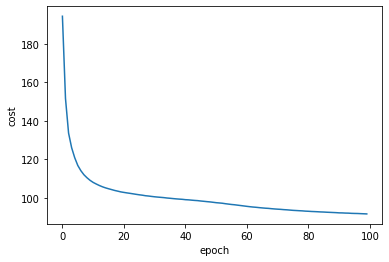

In [4]:
# z dimension이 10인 VAE의 구조를 저장
# 784 500 500 10 500 500 784
network_architecture = dict(n_hidden_recog_1=500,\
                            n_hidden_recog_2=500,\
                            n_hidden_gener_1=500,\
                            n_hidden_gener_2=500,\
                            n_input=784,\
                            n_z=10)

cvae = CVariationalAutoEncoder(network_architecture) # z dimension이 10인 VAE instance 생성

cvae.train(trainX,trainLabel,batch_size=100,training_epochs=100,learning_rate=0.001) # VAE training

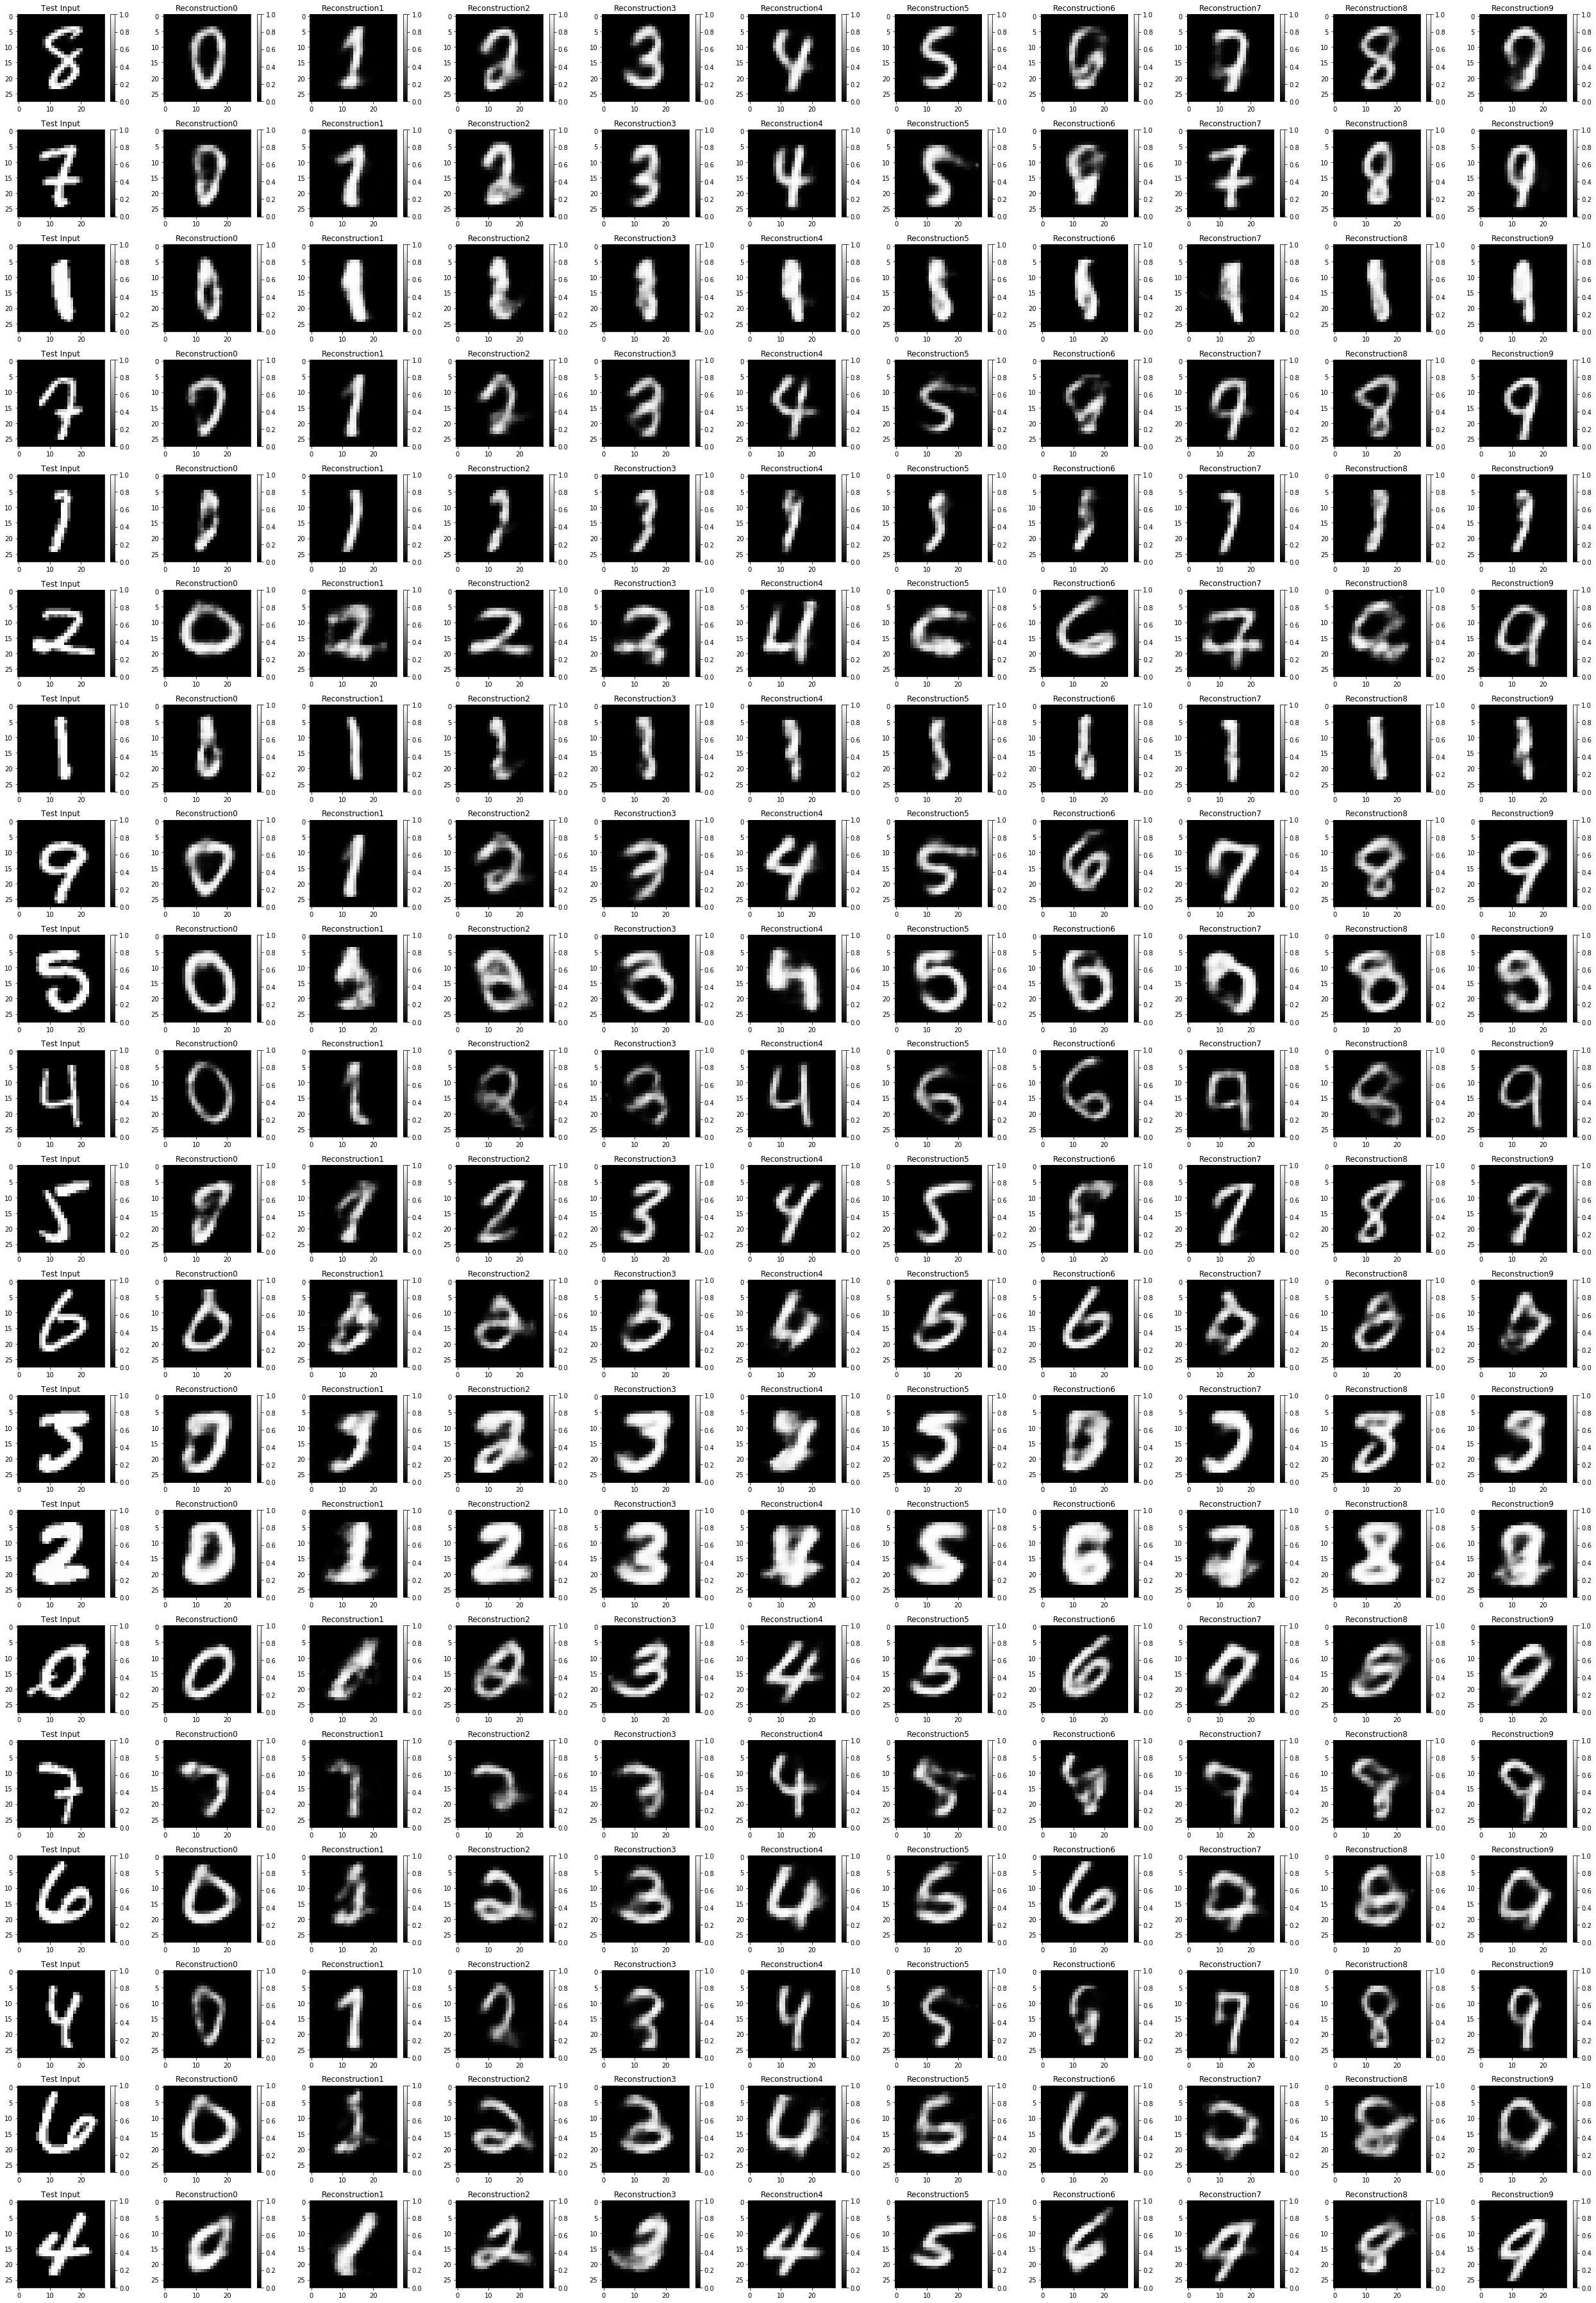

In [5]:
cvae.plotReconstruct(testX,100,'./log/VAE-Reconstruct.png') # testX를 이용하여 reconstruct한 후 이를 plot

## 결과해석부1

위의 출력 결과는 latent space가 10차원인 CVAE로 학습한 결과입니다.

출력문은 각 epoch의 average cost와 실행 소요 시간을 나타낸 것이며, 그래프는 x축은 epoch, y축은 cost로 epoch에 따른 cost의 변화를 표현한 것입니다.  
또한 출력된 10개의 image 중 가장 좌측의 column은 Original Input test image이고, 우측은 좌측의 데이터를 0부터 9까지 각각 다른 label을 붙여 reconstruct한 Output image입니다.

위의 출력 결과를 통해 Training을 진행할수록(Epoch가 증가할수록), total cost가 꾸준히 감소함을 확인할 수 있습니다.
Original input data image에 따라 맞는 label을 붙인 output data가 잘 reconstruct되었으므로, 이는 구현한 CVAE가 유의미하게 learning되었음을 알 수 있습니다.

같은 data에 다른 label을 붙일 경우, label이 output의 reconstruct에 큰 영향을 주고 있으므로 condition이 의미가 있음을 알 수 있습니다.

## CVAE with 2 dimension of latent space

Epoch :  0001  Cost =  235.438186091
Elapsed Time : 10.293112993240356
Epoch :  0002  Cost =  206.308136819
Elapsed Time : 21.233859539031982
Epoch :  0003  Cost =  206.000673329
Elapsed Time : 32.943167209625244
Epoch :  0004  Cost =  204.249079756
Elapsed Time : 43.55909776687622
Epoch :  0005  Cost =  192.607769498
Elapsed Time : 54.425888776779175
Epoch :  0006  Cost =  181.977001676
Elapsed Time : 64.64304542541504
Epoch :  0007  Cost =  175.118030895
Elapsed Time : 76.4433023929596
Epoch :  0008  Cost =  171.104192283
Elapsed Time : 87.75483751296997
Epoch :  0009  Cost =  167.507138339
Elapsed Time : 100.80437541007996
Epoch :  0010  Cost =  164.180192427
Elapsed Time : 112.67758870124817
Epoch :  0011  Cost =  160.700281317
Elapsed Time : 123.6693058013916
Epoch :  0012  Cost =  157.460207298
Elapsed Time : 133.81650829315186
Epoch :  0013  Cost =  154.542923528
Elapsed Time : 144.30351161956787
Epoch :  0014  Cost =  152.036201061
Elapsed Time : 159.51632690429688
Epoch :  001

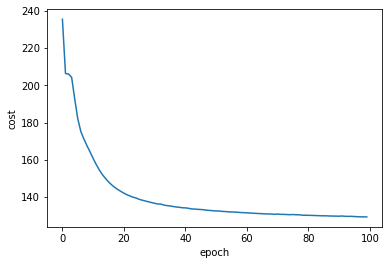

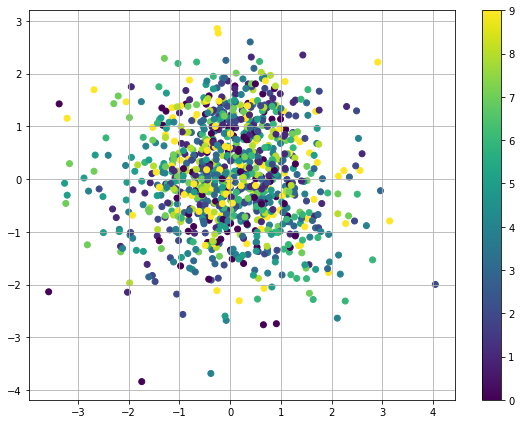

In [6]:
# z dimentsion이 2인 VAE의 구조를 저장
# 784 500 500 2 500 500 784
network_architecture2D = dict(n_hidden_recog_1=500,\
                            n_hidden_recog_2=500,\
                            n_hidden_gener_1=500,\
                            n_hidden_gener_2=500,\
                            n_input=784,\
                            n_z=2)

testX,testY = mnist.test.next_batch(1000) # test data 1000개

cvae2D = CVariationalAutoEncoder(network_architecture2D) # latent variable이 2차원이므로 평면에 점을 찍어 나타낼 수 있다.
cvae2D.train(trainX,trainLabel,batch_size=1000,training_epochs=100,learning_rate=0.001)
cvae2D.plotScatter2D(testX,testY,'./log/VAE-2D-Scatter.png')

## Comparing with t-SNE graph

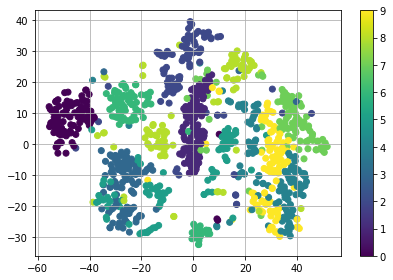

In [8]:
model = TSNE(learning_rate=100) #t-SNE
transformed = model.fit_transform(testX) # t-SNE의 결과를 반환해준다

df = pd.DataFrame()
df['x'], df['y'] = transformed[:,0], transformed[:,1]

cs = [] # one-hot vector로 들어가있는 label을 숫자로 표현해서 색으로 사용할 것이다.
for i in range(len(testY)):
    for j in range(10):
        if testY[i][j] == 1:
            cs.append([j])
df['c'] = np.array(cs)

plt.scatter(df['x'], df['y'], c=df['c'])
plt.colorbar()
plt.grid()

plt.tight_layout()
plt.show()

## 결과 해석부2

위의 출력 결과는 latent space가 2차원인 CVAE로 학습한 결과입니다.

출력문은 각 epoch의 average cost와 실행 소요 시간을 나타낸 것이며, 그래프는 x축은 epoch, y축은 cost로 그래프를 표현한 것입니다.  
그 다음 그래프는 색깔로 label(= digit)을 표현한 test data가 2차원 latent space의 scatter plot입니다.  

latent space가 10차원인 경우와 유사하게 Training을 진행할수록 cost가 감소하는 것을 확인할 수 있습니다.  

Scatter plot에서는 서로 다른 여러 색의 점이 섞여있는 것으로 보아, VAE와는 다르게 input으로 다른 data를 넣어도 latent value에 큰 차이가 없다는 것을 알 수 있습니다. 이것은 CVAE에서 condition이 얼마나 큰 영향을 가지는지 보여준다고 할 수 있습니다.

아래 그래프는 t-SNE 그래프입니다. 위의 latent variable로 구성된 그래프와는 달리, label에 의해 잘 분류된 점들을 보여줍니다.